In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
import numpy as np

from sklearn.manifold import TSNE
import seaborn as sns

# dataframe preprocessing

In [28]:
df = pd.read_csv("ppi.csv") # reading in df
df = df[df["sequence"]!= 'X'] # Removing the spooky amino-acid x
df = df[df.columns[1:]]     # removing unnamed column
df["aa_RelatPosition"] = df["aa_ProtPosition"] / df["Rlength"] # adding a relative position of the amino acid
df = df[[c for c in df if c not in ["aa_ProtPosition","Rlength",'p_interface','domain']] + ['p_interface']] # removing columns not to be used as features (and ensuring p_interface is the last one)

test_size = 50
testproteins = random.sample(list(df["uniprot_id"].unique()),test_size)
trainproteins = set(df["uniprot_id"].unique()) - set(testproteins) 


In [131]:
# scramble the rows
df_train = df[df["uniprot_id"].isin(trainproteins)].sample(frac=1) # which protein_id's to use and sample to scramble rows
df_test = df[df["uniprot_id"].isin(testproteins)].sample(frac=1)

X_train = df_train[df_train.columns[:-1]].select_dtypes("number")
Y_train = df_train["p_interface"]

X_test = df_test[df_test.columns[:-1]].select_dtypes("number")
Y_test= df_test["p_interface"]

if True:
    # count the number of P_interface=1 amd sample as many p_interface=0 as that 
    new_x = df_train[df_train["p_interface"]==0].sample(list(df_train["p_interface"]).count(1))
    new_y = df_train[df_train["p_interface"]==1]
    # make this a single dataframe
    df_train = pd.concat([new_x,new_y])
    # splitting this into x and y (i could shorten this but this is gives more oversight)
    X_train = df_train[df_train.columns[:-1]].select_dtypes("number")
    Y_train = df_train[df_train.columns[-1]]

# TSNE Analysis

In [141]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)


tsne_results = tsne.fit_transform(X_train)

# handy dataframe but unnecesary


C:\Users\maxvV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12360 samples in 0.006s...
[t-SNE] Computed neighbors for 12360 samples in 0.393s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12360
[t-SNE] Computed conditional probabilities for sample 2000 / 12360
[t-SNE] Computed conditional probabilities for sample 3000 / 12360
[t-SNE] Computed conditional probabilities for sample 4000 / 12360
[t-SNE] Computed conditional probabilities for sample 5000 / 12360
[t-SNE] Computed conditional probabilities for sample 6000 / 12360
[t-SNE] Computed conditional probabilities for sample 7000 / 12360
[t-SNE] Computed conditional probabilities for sample 8000 / 12360
[t-SNE] Computed conditional probabilities for sample 9000 / 12360
[t-SNE] Computed conditional probabilities for sample 10000 / 12360
[t-SNE] Computed conditional probabilities for sample 11000 / 12360
[t-SNE] Computed conditional probabilities for sample 12000 / 12360
[t-SNE] Computed conditional probabilities for sa

#  Train a regression model to predict the t-SNE embedding

In [146]:
# Import dependencies for 3d plotting
import plotly
import plotly.graph_objs as go

def plot3d_ab(x,y,z,colorlist):
    
    trace = go.Scatter3d(x=x,y=y,z=z,mode='markers',
                         marker={'size': 5,"color":colorlist},line={'width':3},name="ptm structure")
    
    # Configure the layout.
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    data = [trace]
    plot_figure = go.Figure(data=data, layout=layout)
    # Render the plot.
    
    plot_figure.update_layout(autosize=True) # remove height=800
    #plot_figure.show(renderer="browser")  # remove display(fig)
    plot_figure.write_html("plot.html")
    # Adding vertical lines at z = 0
    
    plotly.offline.iplot(plot_figure)


plot3d_ab(x = tsne_results[:,0],y = tsne_results[:,1],z = tsne_results[:,2],colorlist = Y_train)

In [137]:
from sklearn.ensemble import RandomForestRegressor

# Train a regression model to predict the t-SNE embedding
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, tsne_results)



KeyboardInterrupt: 

In [115]:
# Now use this regressor to predict the t-SNE embedding of the test data
X_test_tsne_pred = regressor.predict(X_test)


# Apply kNN to classify the predicted t-SNE embedding

In [118]:
from sklearn.neighbors import KNeighborsClassifier

# Train a k-NN classifier on the original t-SNE embedding of the training data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tsne_results, Y_train)

# Predict the class of the t-SNE embedding for the test data
y_pred = knn.predict(X_test_tsne_pred)


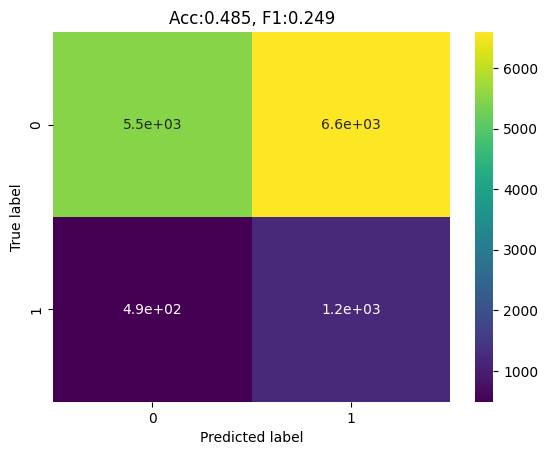

In [120]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(Y_test,y_pred),annot=True,cmap="viridis")
plt.title(f"Acc:{round(accuracy_score(Y_test,y_pred),3)}, F1:{round(f1_score(Y_test, y_pred),3)}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

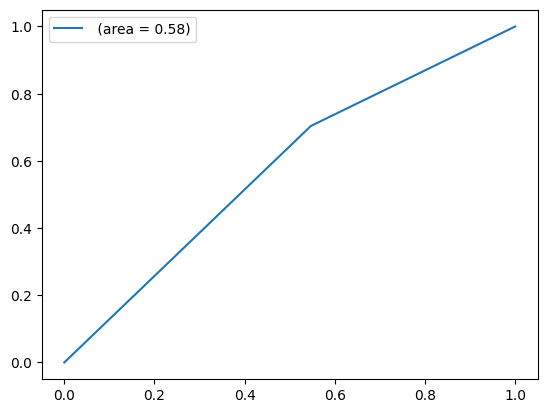

In [112]:

curve  = roc_curve(Y_test, y_pred)
auc_  = auc(curve[0], curve[1])

plt.plot(curve[0], curve[1], label=f' (area = {round(auc_,2)})')
plt.legend()

20 0.23106860891804737
21 0.2325769854132901
22 0.23190952014933566
23 0.23134852896877198
24 0.23105938139885762
25 0.23367560562257003
26 0.23364685763146645
27 0.23411437648927721
28 0.234180580665745
29 0.2375494071146245
30 0.23524451939291738
31 0.23693516699410608
32 0.23738376345209486
33 0.23842751842751841
34 0.23885880882965432
35 0.24025083284342544
36 0.24189035133174422
37 0.2413020173472371
38 0.23854903166308022
39 0.23928467295169598
40 0.2400162999185004
41 0.23947470065662418
42 0.23931623931623933
43 0.24081041968162084
44 0.23875748654958887
45 0.23904688700999233
46 0.2388961627555645
47 0.2406273909716909
48 0.23887166149844954
49 0.24039747754634053


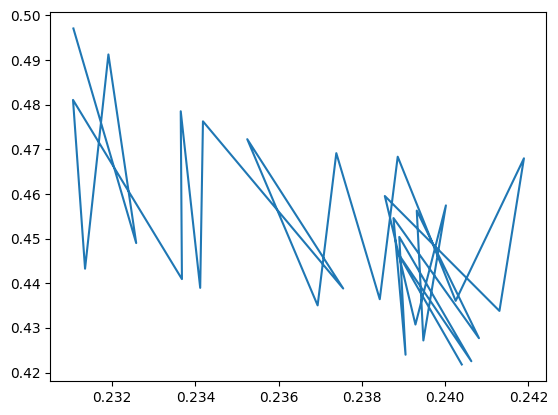

In [ ]:
ls = []
ls2 = []
for i in range(20,50):
# Train a k-NN classifier on the original t-SNE embedding of the training data
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(tsne_results, Y_train)

    # Predict the class of the t-SNE embedding for the test data
    y_pred = knn.predict(X_test_tsne_pred)
    ls.append(f1_score(Y_test, y_pred))
    print(i,f1_score(Y_test, y_pred))
    ls2.append(accuracy_score(Y_test,y_pred))



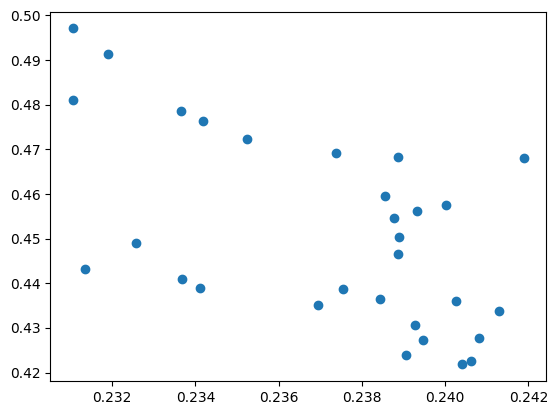

In [94]:
plt.scatter(ls,ls2)